In [9]:
%matplotlib widget
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.laplacian_pyramid import quantise
from scipy.ndimage import zoom

# 10. Selection of preferred energy compaction options

The remainder of this project will concentrate on developing the rest of
an image compression system, based on a few of the filtering /
transformation schemes studied so far.

Since the subsequent processes are non-linear, we cannot expect to be able to
choose precisely the right front-end at this stage, so we adopt the pragmatic
approach of picking about three good candidates and trust that one of these
will lead to a near-optimum solution in the end. Remember that up to this point we have only been using entropy to give us an _estimate_ of the number of bits required, the accuracy of which is affected by subsequent stages.

At this stage it is worth trying your schemes with all three
test images, (`Lighthouse`, `Bridge`, and `Flamingo`). You will find `Bridge` more difficult to compress than the other two. You may also want to introduce other images of your own.

In [10]:
lighthouse, _ = load_mat_img(img='lighthouse.mat', img_info='X')
bridge, _ = load_mat_img(img='bridge.mat', img_info='X')
flamingo, _ = load_mat_img(img='flamingo.mat', img_info='X')

In [11]:
# import scipy.io
# import numpy as np
# from PIL import Image

# # List of TIFF image paths
# tif_image_paths = ['lake.tif', 'boats.tif', 'baboon.tif', 'couple.tif', 'plane.tif']
# mat_file_paths = ['lake.mat', 'boats.mat', 'baboon.mat', 'couple.mat', 'plane.mat']

# # Process each image
# for tif_path, mat_path in zip(tif_image_paths, mat_file_paths):
#     # Load the TIFF image
#     img = Image.open(tif_path).convert("L")  # Convert to grayscale if necessary
    
#     # Convert the image to a NumPy array
#     img_array = np.array(img)
    
#     # Save the image array to a MAT file
#     scipy.io.savemat(mat_path, {'image': img_array})
#     print(f'{tif_path} has been converted to {mat_path}')

# # List the created files
# mat_file_paths

In [12]:
lena, _ = load_mat_img(img='lena.mat', img_info='image')
peppers, _ = load_mat_img(img='peppers.mat', img_info='image')
columbia, _ = load_mat_img(img='columbia.mat', img_info='image')
camera, _ = load_mat_img(img='camera.mat', img_info='image')

print(columbia.shape)

(480, 480)


In [13]:
peppers = zoom(peppers, 256/512)
columbia = zoom(columbia, 256/480)
lena = zoom(lena, 256/512)

print(peppers.shape, columbia.shape, lena.shape)

(256, 256) (256, 256) (256, 256)


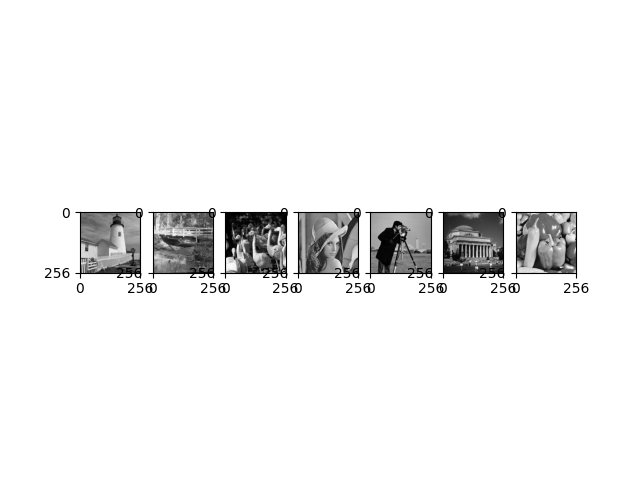

In [14]:
fig, axs = plt.subplots(1, 7)
plot_image(lighthouse, ax=axs[0])
plot_image(bridge, ax=axs[1])
plot_image(flamingo, ax=axs[2])
plot_image(lena, ax=axs[3])
plot_image(camera, ax=axs[4])
plot_image(columbia, ax=axs[5])
plot_image(peppers, ax=axs[6])

Write `.py` files to implement each of your
chosen schemes, so that you do not have to remember long sequences
of commands each time you run them. You can easily edit the M-files to introduce different options
later.  Using plenty of comments in these files will help when you want to change them.

# 11. Centre-clipped linear quantisers

The quantisers that you have used so far have all been uniform quantisers
(i.e.  all steps have been the same size).  However the probability
distributions of the intensities of the bandpass sub-images from the energy
compaction front-ends are usually highly peaked at zero.  The amount of data
compression depends heavily on the proportion of data samples which are
quantised to zero; if this approaches unity then high compression is
achieved.

Hence it is often found desirable to make the quantiser non-linear
so that more samples tend to be quantised to zero.  A simple way
to achieve this is to widen the step-size of the "zero" step.  In
a uniform quantiser, the "zero" step is normally centred on zero,
with rises to the next level at $\pm$ half of the step-size on
each side of zero. `quantise` allows a third argument `rise1` to be specified, which is
the point at which the first rise occurs on each side of the zero step.  A
value of `rise1` = `step/2` is the default, but `rise1` = $\left\{0.5, 1, 1.5\right\}\times$ `step` are worth investigating. To show what effect these have, try:

```python
x = np.arange(-100, 100+1)
y = quantise(x, 20, rise1)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.grid()
```

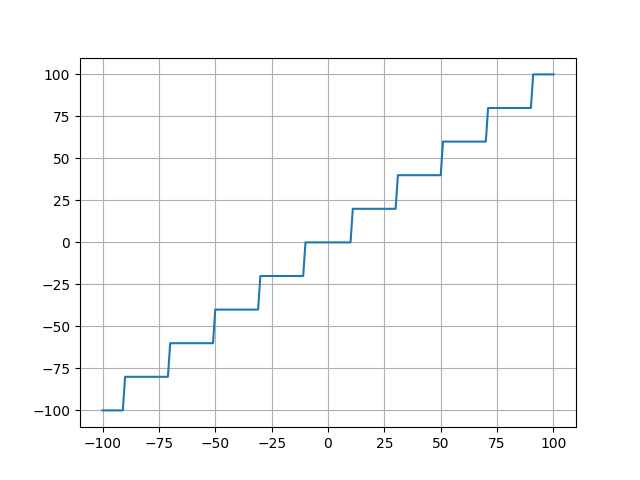

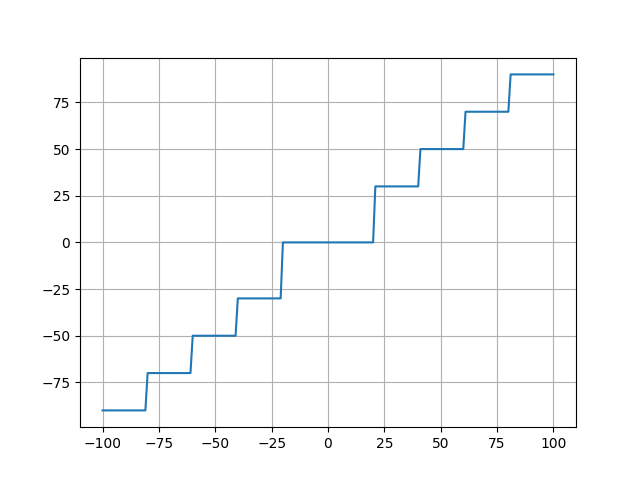

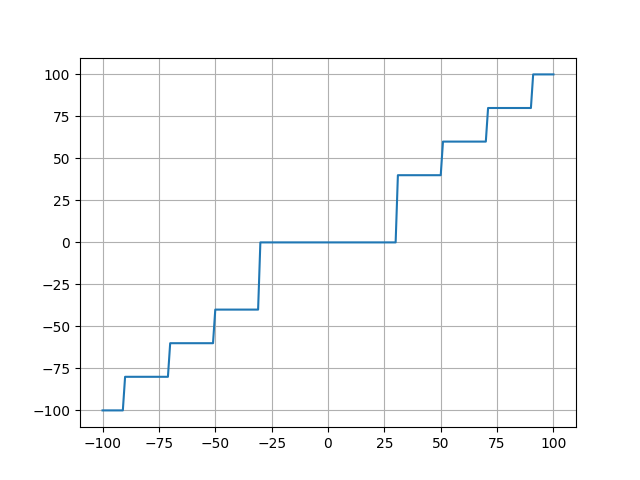

In [15]:
# your code here
for rise1 in [0.5, 1, 1.5]:
    step = 20
    rise1 = step*rise1
    x = np.arange(-100, 100+1)
    y = quantise(x, step, rise1)
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.grid()

A wider zero step means that more samples will be coded as zero and so the
entropy of the data will be reduced.  The use of a wide zero step is
beneficial if it results in a better entropy vs. error tradeoff than a uniform
quantiser.

<div class="alert alert-block alert-danger">

For each of your preferred front-end
schemes, investigate the effects of varying the first rise of the
quantiser.  To do this, you could plot how the quantising error
varies as a function of the number of bits for a few different ratios of
`rise1` to step-size, and hence find the ratio which gives the
best compression for a given rms error. </div>

In [16]:
lighthouse = lighthouse - 128.0
bridge = bridge - 128.0
camera = camera - 128.0
flamingo = flamingo - 128.0
columbia = columbia - 128.0
lena = lena - 128.0
peppers = peppers - 128.0

In [17]:
# You may wish to work in standalone python files (instead of notebooks) at this point!
from chosen_schemes.dct import reconstruct_dct, find_step_size_for_compression_bits_dct
from chosen_schemes.lbt import reconstruct_lbt, find_step_size_for_compression_bits_lbt
from chosen_schemes.dwt import reconstruct_dwt, find_step_size_for_compression_bits_dwt, compute_ss_ratios

rise_ratios = [0.5, 0.75, 1, 1.25, 1.5]
target_bits_range = np.linspace(10000, 300000, 100)
results_dct = {0.5: {'bits': [], 'rmse': []}, 0.75: {'bits': [], 'rmse': []}, 1: {'bits': [], 'rmse': []}, 1.25: {'bits': [], 'rmse': []}, 1.5: {'bits': [], 'rmse': []}}
results_lbt = {0.5: {'bits': [], 'rmse': []}, 0.75: {'bits': [], 'rmse': []}, 1: {'bits': [], 'rmse': []}, 1.25: {'bits': [], 'rmse': []}, 1.5: {'bits': [], 'rmse': []}}
results_dwt = {0.5: {'bits': [], 'rmse': []}, 0.75: {'bits': [], 'rmse': []}, 1: {'bits': [], 'rmse': []}, 1.25: {'bits': [], 'rmse': []}, 1.5: {'bits': [], 'rmse': []}}

image = columbia

10001.863265411504 15.723530173765651 161.12471063587338
12923.449510425911 13.89960632230954 129.44983019799193
15854.065365976145 12.596719899045445 108.64369132774148
18788.24341381121 11.53128510231214 93.10179639840865
21724.21154507639 10.620104012107603 80.97872528723857
24657.101335471853 9.870476610299855 72.02210028804554
27572.474432809544 9.236276199669271 64.88971646422988
30505.15393121794 8.647191661926598 58.64165728687085
33437.652916915154 8.119965750659368 53.34649480105442
36365.393261025274 7.706277172219851 49.106810721823436
39293.789749356176 7.297116988724317 45.3375502852153
42228.222011496895 6.903671286711806 41.846131962093295
45151.63438108002 6.5292556323806945 38.869869834531976
48094.22057126872 6.20302839797288 36.20970533574257
50939.782366827865 5.897565678318103 33.82496010774624
53939.25889216399 5.59385552279829 31.46882868174907
56868.169478642674 5.320405418499747 29.3870485656887
59811.19127120494 5.069400956730839 27.522569391106487
62719.1210

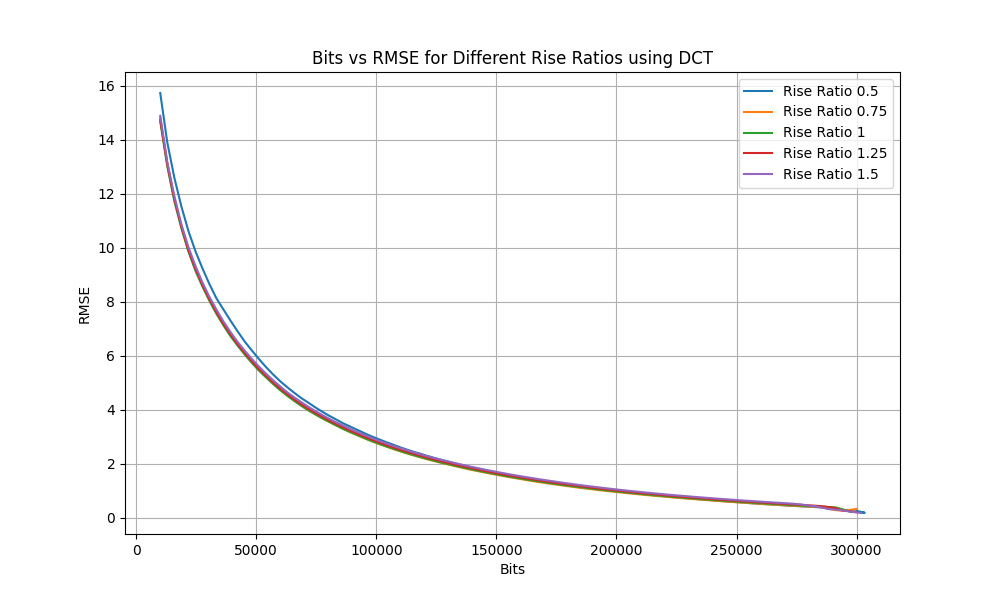

In [18]:
for rise in rise_ratios:
    for target_bits in target_bits_range:
        step_size = find_step_size_for_compression_bits_dct(image, 8, target_bits, rise, min_step_size=0.01, max_step_size=200, tolerance=1e-5)
        bits_dct, rmse_dct, Z_dct = reconstruct_dct(image, step_size, 8, rise)
        print(bits_dct, rmse_dct, step_size)
        results_dct[rise]['bits'].append(bits_dct)
        results_dct[rise]['rmse'].append(rmse_dct)

# Plot the results
plt.figure(figsize=(10, 6))

for rise in rise_ratios:
    plt.plot(results_dct[rise]['bits'], results_dct[rise]['rmse'], label=f'Rise Ratio {rise}')

plt.xlabel('Bits')
plt.ylabel('RMSE')
plt.title('Bits vs RMSE for Different Rise Ratios using DCT')
plt.legend()
plt.grid(True)
plt.show()


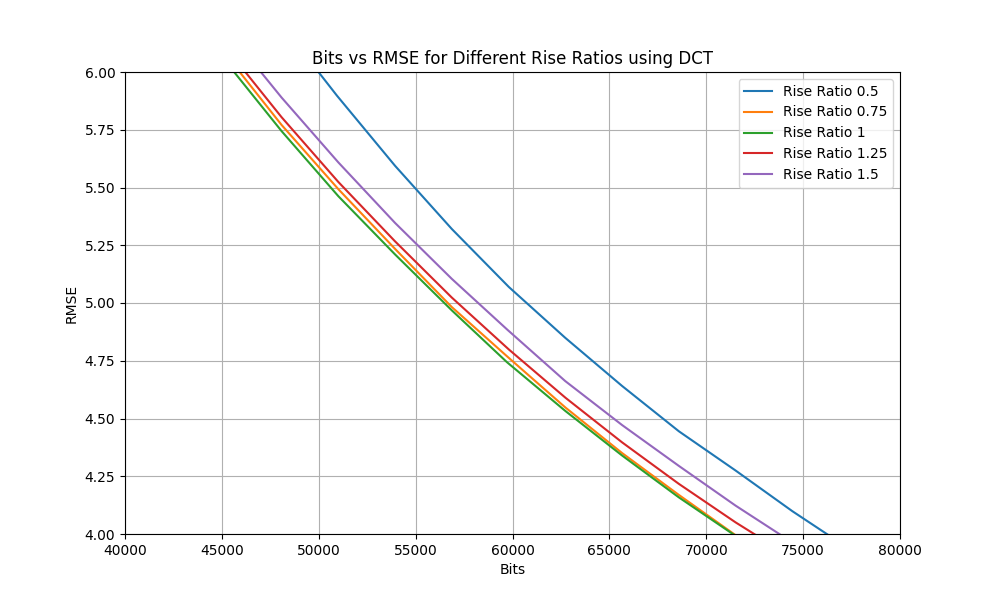

In [19]:
plt.figure(figsize=(10, 6))

# Plotting the main graph
for rise in rise_ratios:
    plt.plot(results_dct[rise]['bits'], results_dct[rise]['rmse'], label=f'Rise Ratio {rise}')

plt.xlabel('Bits')
plt.ylabel('RMSE')
plt.title('Bits vs RMSE for Different Rise Ratios using DCT')
plt.legend()
plt.grid(True)

# Setting the x and y axis limits for the constrained portion
plt.xlim(40000, 80000)
plt.ylim(4, 6)

plt.show()

10000.16422071229 17.154809582270378 183.61939180121269
12931.537391044583 14.166084710860533 145.51213118081725
15859.375368357514 12.903410977789788 121.12082970997562
18788.590393807226 11.370495166273113 102.06056759380724
21720.837611205716 10.17495509335923 86.6581406079059
24644.87970330658 9.369657291612755 77.03357584305371
27554.968957455487 8.539962489731359 67.88437039698472
30506.80036236977 7.942591751893286 60.801561562928285
33492.836189048954 7.334779121482244 54.502801716642644
36394.99023238277 6.926227426546227 49.720438237785594
39296.42374842258 6.484657946638975 45.44261717824934
42223.95881612487 6.096412874036429 41.62341818135186
45155.55514010518 5.759350660348997 38.60934805076254
48074.477755973465 5.422260854978814 35.546320185230734
51008.80859525809 5.120167759146068 33.00432002698326
53942.01253292641 4.814735487554864 30.488752735157906
56869.53980793694 4.5845883844479145 28.441349030426686
59800.376808719055 4.356177926715794 26.506091635688573
62717

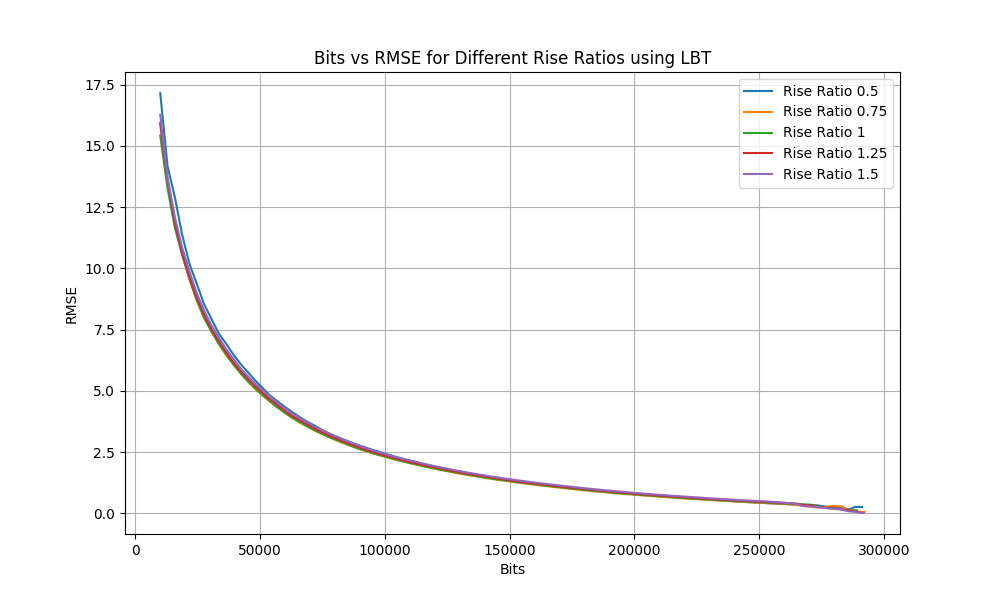

In [20]:
for rise in rise_ratios:
    for target_bits in target_bits_range:
        step_size = find_step_size_for_compression_bits_lbt(image, 4, target_bits, rise, min_step_size=0.01, max_step_size=200, tolerance=1e-5)
        bits_dct, rmse_dct, Z_dct = reconstruct_lbt(image, step_size, rise, N=4, s=1.32)
        print(bits_dct, rmse_dct, step_size)
        results_lbt[rise]['bits'].append(bits_dct)
        results_lbt[rise]['rmse'].append(rmse_dct)

# Plot the results
plt.figure(figsize=(10, 6))

for rise in rise_ratios:
    plt.plot(results_lbt[rise]['bits'], results_lbt[rise]['rmse'], label=f'Rise Ratio {rise}')

plt.xlabel('Bits')
plt.ylabel('RMSE')
plt.title('Bits vs RMSE for Different Rise Ratios using LBT')
plt.legend()
plt.grid(True)
plt.show()

9990.849801679224 14.349992533358272 6.269995738187484
12917.232759943874 12.92993699948699 5.101564525301206
15850.45029781007 11.847661924178865 4.3604636281176985
18812.050103350957 10.914292792185408 3.8467490865028844
21736.49615416435 10.197931870397483 3.4455235964686266
24645.96263327843 9.538354213778332 3.102199041258702
27581.78253883169 8.959244888911051 2.8169063391755174
30529.841144630394 8.4057924395136 2.570465992838618
33432.835698051735 7.90917086758306 2.3576594155302195
36363.37680771806 7.397273415264839 2.168691274174745
39321.439338319076 6.9835132371164415 2.0002413161358543
42198.543294350566 6.58578510886187 1.8426509757341087
45127.73699124354 6.237039021403153 1.705453002511475
48095.272537385434 5.939680108161317 1.5866279991475716
51005.63201367584 5.617186664410264 1.4782481075414726
53898.169081531305 5.356409978892545 1.3822593668466996
56826.26448815241 5.113277822231888 1.2967429497592429
59852.601814051995 4.878002707706264 1.2216256295391632
62725.

227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069736 0.21414342472693354 0.03455635420475101
227957.0478069

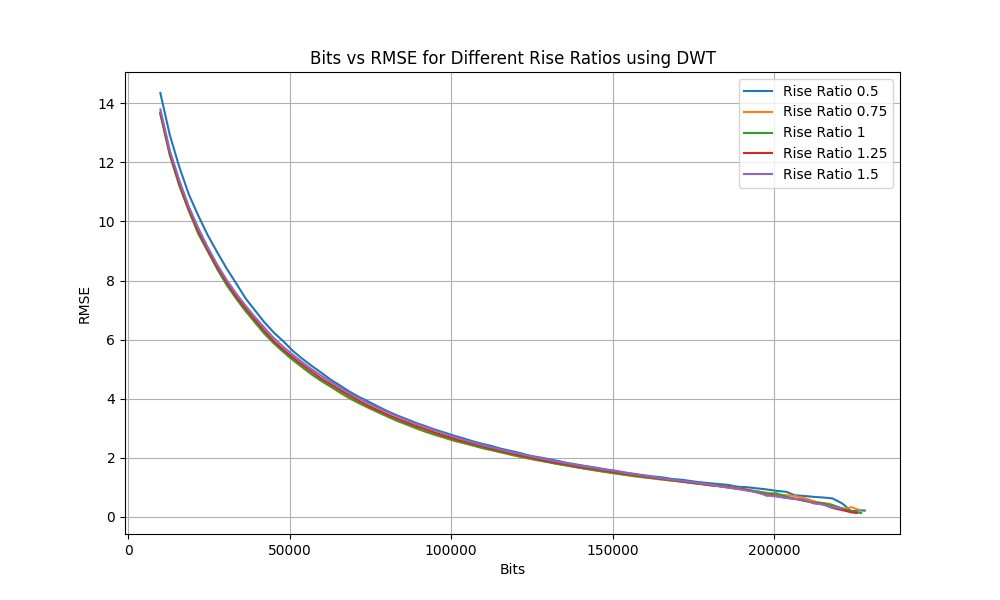

In [21]:
for rise in rise_ratios:
    for target_bits in target_bits_range:
        ssrs = compute_ss_ratios(5)
        overall_mult = find_step_size_for_compression_bits_dwt(ssrs, image, 5, target_bits, rise, min_om=0.01, max_om=50, tolerance=1e-5)
        bits_dwt, rmse_dwt, Z_dwt = reconstruct_dwt(image, ssrs, overall_mult, 5, rise)
        print(bits_dwt, rmse_dwt, overall_mult)
        results_dwt[rise]['bits'].append(bits_dwt)
        results_dwt[rise]['rmse'].append(rmse_dwt)

# Plot the results
plt.figure(figsize=(10, 6))

for rise in rise_ratios:
    plt.plot(results_dwt[rise]['bits'], results_dwt[rise]['rmse'], label=f'Rise Ratio {rise}')

plt.xlabel('Bits')
plt.ylabel('RMSE')
plt.title('Bits vs RMSE for Different Rise Ratios using DWT')
plt.legend()
plt.grid(True)
plt.show()

Most current image compression standards use quantisers with a
double-width centre step (`rise1 = step`). Do not spend too much time
on this as the compression gains are likely to be quite small.

<div class="alert alert-block alert-danger">


Discuss whether your results indicate that `rise1 = step`
is a reasonable compromise if all quantisers are to be similar.
</div>

A final strategy which you can consider is to completely suppress some
sub-images or DCT coefficients.  This is equivalent to increasing `rise1`
to a very large value for these components.  In the sub-images / coefficients
which represent only the highest horizontal and vertical frequency components
combined, the effects of suppression can be almost unnoticable and yet
a useful saving in number of bits can be achieved.

<div class="alert alert-block alert-danger">

Investigate any additional gains which can be achieved with suppression
of some sub-images / coefficients.
</div>

222.8313222786069 49.771762969120445 188.0111880570684
249.25439558018624 49.748873716930376 151.7978242497038
267.98365704577435 49.75430007738679 124.85094426540967
281.26239631165794 49.75196138029289 109.33535706987072
303.7795492662 49.74463147633689 99.8117705610138
333.1788459405175 49.747483073943776 84.60304819880946
340.27814038231804 49.74717266678471 75.54003454097179
359.4430881299416 49.74614282790857 68.55281253847518
397.43137181695414 49.743140736095896 62.57848554129625
417.19052929205935 49.74498450610628 57.321741597102616
430.17479921962826 49.74365876464335 53.016539235274294
457.8622032205665 49.74233655312131 49.09524968690547
500.35813408798776 49.74158665103936 45.57587299542877
533.4336034998 49.743271754160716 42.415450915705044
565.180839603909 49.74340865539356 39.725964255317976
583.608095106475 49.594341176767344 37.322214907305344
614.4366961941281 49.46143249728859 35.12387609837502
646.7057137206866 49.3425713861961 33.12324600940915
710.4470361533118

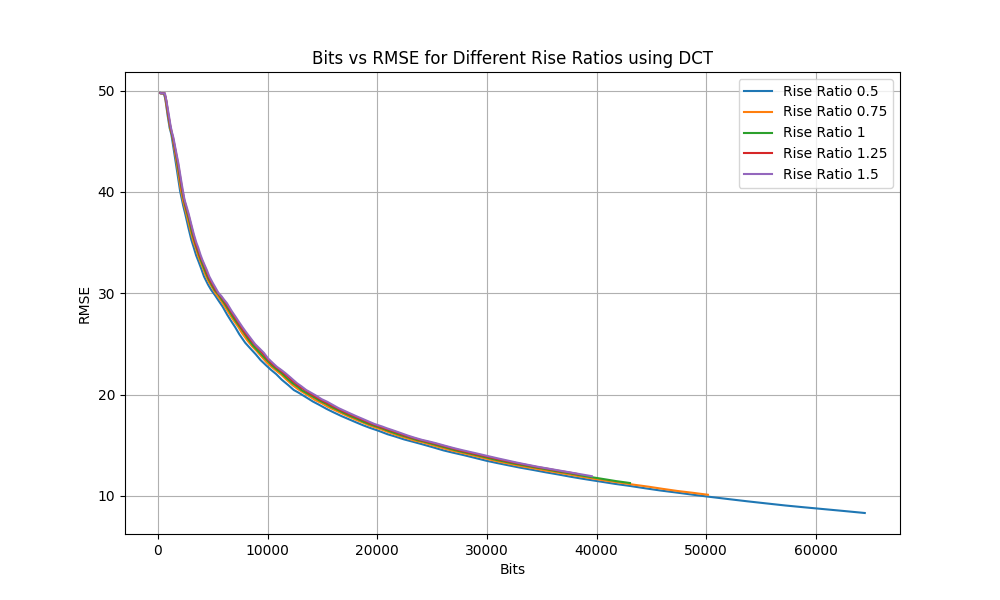

In [25]:
from chosen_schemes.dct import reconstruct_dct_suppressed_hf

image = lighthouse
results_dct_supp = {0.5: {'bits': [], 'rmse': []}, 0.75: {'bits': [], 'rmse': []}, 1: {'bits': [], 'rmse': []}, 1.25: {'bits': [], 'rmse': []}, 1.5: {'bits': [], 'rmse': []}}

for rise in rise_ratios:
    for target_bits in target_bits_range:
        step_size = find_step_size_for_compression_bits_dct(image, 8, target_bits, rise, min_step_size=0.01, max_step_size=200, tolerance=1e-5)
        bits_dct, rmse_dct, Z_dct = reconstruct_dct_suppressed_hf(image, step_size, 8, rise)
        print(bits_dct, rmse_dct, step_size)
        results_dct_supp[rise]['bits'].append(bits_dct)
        results_dct_supp[rise]['rmse'].append(rmse_dct)

# Plot the results
plt.figure(figsize=(10, 6))

for rise in rise_ratios:
    plt.plot(results_dct_supp[rise]['bits'], results_dct_supp[rise]['rmse'], label=f'Rise Ratio {rise}')

plt.xlabel('Bits')
plt.ylabel('RMSE')
plt.title('Bits vs RMSE for Different Rise Ratios using DCT')
plt.legend()
plt.grid(True)
plt.show()






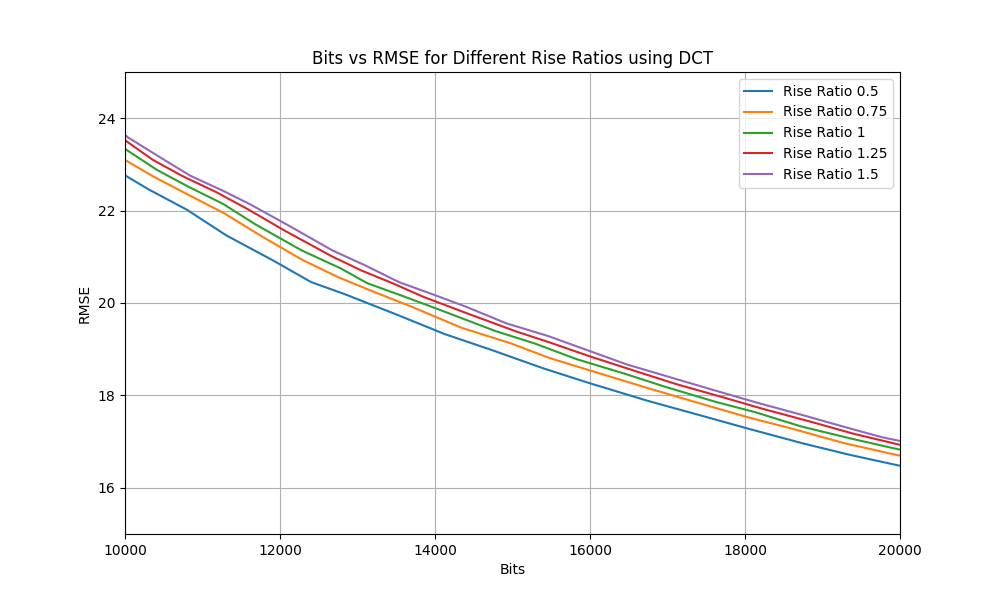

In [27]:
plt.figure(figsize=(10, 6))

# Plotting the main graph
for rise in rise_ratios:
    plt.plot(results_dct_supp[rise]['bits'], results_dct_supp[rise]['rmse'], label=f'Rise Ratio {rise}')

plt.xlabel('Bits')
plt.ylabel('RMSE')
plt.title('Bits vs RMSE for Different Rise Ratios using DCT')
plt.legend()
plt.grid(True)

# Setting the x and y axis limits for the constrained portion
plt.xlim(10000, 20000)
plt.ylim(15, 25)

plt.show()